**PART 2: Synthetic Pathology Image Generation using DCGAN and cGAN on PathMNIST**

** using DCGAN**

In [ ]:
# -------------------------------------------------------------
# Step 1: Import Required Libraries
# -------------------------------------------------------------
import torch
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from medmnist import PathMNIST
from medmnist import INFO

import os
from torch.utils.data import DataLoader
from torchvision import datasets

# -------------------------------------------------------------
# Step 2: Device Configuration
# -------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA available:", torch.cuda.is_available())
print("Device name:", device)

CUDA available: True
Device name: cuda


In [ ]:
# -------------------------------------------------------------
# Step 3: Load and Prepare PathMNIST Dataset
# -------------------------------------------------------------

# Choose the dataset
data_flag = 'pathmnist'
download = True

# Load dataset metadata
info = INFO[data_flag]
DataClass = getattr(__import__('medmnist'), info['python_class'])

# Define image transformation: convert to tensor + normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])  # normalize to [-1, 1]
])


# Load training and test datasets
train_dataset = DataClass(split='train', transform=transform, download=download)
test_dataset = DataClass(split='test', transform=transform, download=download)

# Define data loaders
batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Print basic dataset information
print(f"Description: {info.get('description', 'No description')}")
print(f"Classes: {info['label']}")
print(f"Train size: {len(train_dataset)} | Test size: {len(test_dataset)}")


Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.
Classes: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
Train size: 89996 | Test size: 7180


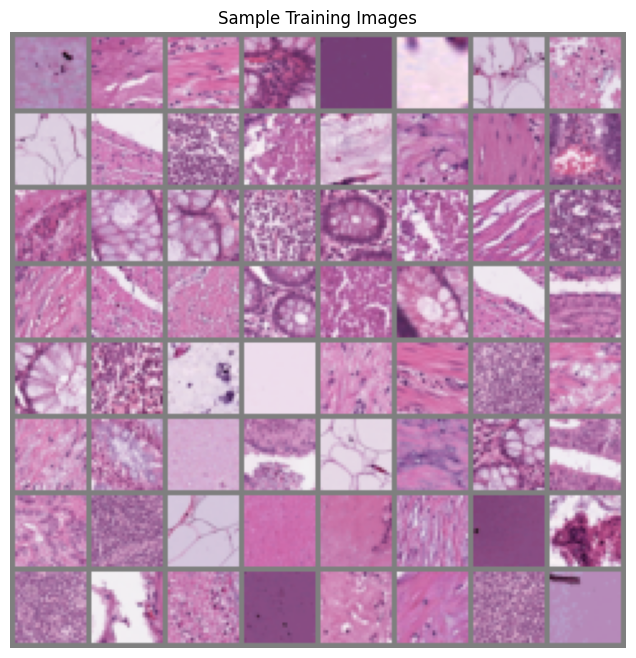

In [ ]:
# Function to show a batch of images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize from [-1, 1] to [0, 1]
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.title("Sample Training Images")
    plt.show()

# Grab a batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show a grid of 64 images (8x8)
imshow(torchvision.utils.make_grid(images[:64], nrow=8))



In [ ]:
# -------------------------------
# Generator Network (DCGAN)
# -------------------------------

class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 4, 7, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 3, 1, 1, bias=False),
            nn.Tanh()  # Output shape: (3, 28, 28)
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
# -------------------------------
# Discriminator Network (DCGAN)
# -------------------------------

class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: (3, 28, 28)
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(ndf * 4 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
# -------------------------------
# Optimizers and Loss Function
# -------------------------------

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
lr = 0.0002
beta1 = 0.5

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

latent_dim = 100 # Size of the input noise vector


In [ ]:
import torchvision.utils as vutils

# Set up paths and parameters
num_epochs = 50
latent_dim = 100
real_label = 1.
fake_label = 0.
checkpoint_path = "dcgan_checkpoint.pth"

# Set fixed noise vector for generating consistent sample images
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

# To store losses and generated images over time
G_losses = []
D_losses = []
img_list = []
start_epoch = 0

# Load checkpoint if exists (resuming training)
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    G_losses = checkpoint['G_losses']
    D_losses = checkpoint['D_losses']
    start_epoch = checkpoint['epoch'] + 1
    print(f"✅ Resumed training from epoch {start_epoch}")
else:
    print("🆕 Starting training from scratch...")

# Directory to save generated images
os.makedirs("generated_samples", exist_ok=True)

# Training Loop
print("🚀 Training Loop Started...")
for epoch in range(start_epoch, num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        b_size = real_images.size(0)
        real_images = real_images.to(device)


        ### --------------------
        ### 1. Train Discriminator
        ### --------------------

        discriminator.zero_grad()
        label = torch.full((b_size,), real_label, device=device)

        # Forward pass real batch
        output_real = discriminator(real_images).view(-1)
        loss_real = criterion(output_real, label)
        loss_real.backward()
        D_x = output_real.mean().item()

        # Generate fake images
        noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)

        # Classify fake images
        label.fill_(fake_label)
        output_fake = discriminator(fake_images.detach()).view(-1)
        loss_fake = criterion(output_fake, label)
        loss_fake.backward()
        D_G_z1 = output_fake.mean().item()

         # Final loss and update
        loss_D = loss_real + loss_fake
        optimizer_D.step()

        ### --------------------
        ### 2. Train Generator
        ### --------------------
        generator.zero_grad()
        label.fill_(real_label) # Generator wants to fool Discriminator

        output = discriminator(fake_images).view(-1)
        loss_G = criterion(output, label)
        loss_G.backward()
        D_G_z2 = output.mean().item()
        optimizer_G.step()

        # Track losses
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        # Save generated images every 100 batches
        if i % 100 == 0:
            with torch.no_grad():
                fake_sample = generator(fixed_noise).detach().cpu()
            img = vutils.make_grid(fake_sample, padding=2, normalize=True)
            img_list.append(img)
            vutils.save_image(fake_sample, f"generated_samples/epoch{epoch}_batch{i}.png", normalize=True)

    print(f"[{epoch+1}/{num_epochs}] Loss_D: {loss_D:.4f} Loss_G: {loss_G:.4f} D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}")

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'G_losses': G_losses,
        'D_losses': D_losses
    }, checkpoint_path)


🆕 Starting training from scratch...
🚀 Training Loop Started...
[1/50] Loss_D: 0.2728 Loss_G: 3.7667 D(x): 0.7730 D(G(z)): 0.0035/0.0254
[2/50] Loss_D: 0.3275 Loss_G: 3.7959 D(x): 0.7531 D(G(z)): 0.0309/0.0301
[3/50] Loss_D: 0.8614 Loss_G: 2.0709 D(x): 0.6898 D(G(z)): 0.3701/0.1335
[4/50] Loss_D: 1.0825 Loss_G: 3.8791 D(x): 0.7657 D(G(z)): 0.4793/0.0320
[5/50] Loss_D: 0.7339 Loss_G: 3.2988 D(x): 0.9170 D(G(z)): 0.4555/0.0456
[6/50] Loss_D: 0.8051 Loss_G: 7.0508 D(x): 0.9646 D(G(z)): 0.4748/0.0011
[7/50] Loss_D: 0.2486 Loss_G: 3.2123 D(x): 0.8068 D(G(z)): 0.0259/0.0692
[8/50] Loss_D: 0.7410 Loss_G: 2.0763 D(x): 0.5465 D(G(z)): 0.0584/0.1735
[9/50] Loss_D: 0.9591 Loss_G: 3.5524 D(x): 0.7040 D(G(z)): 0.4149/0.0308
[10/50] Loss_D: 2.1685 Loss_G: 0.9309 D(x): 0.1573 D(G(z)): 0.0680/0.4804
[11/50] Loss_D: 0.5994 Loss_G: 1.2343 D(x): 0.6195 D(G(z)): 0.0787/0.3094
[12/50] Loss_D: 0.8619 Loss_G: 1.0663 D(x): 0.5568 D(G(z)): 0.1734/0.4000
[13/50] Loss_D: 0.2916 Loss_G: 4.1793 D(x): 0.7875 D(G(z))

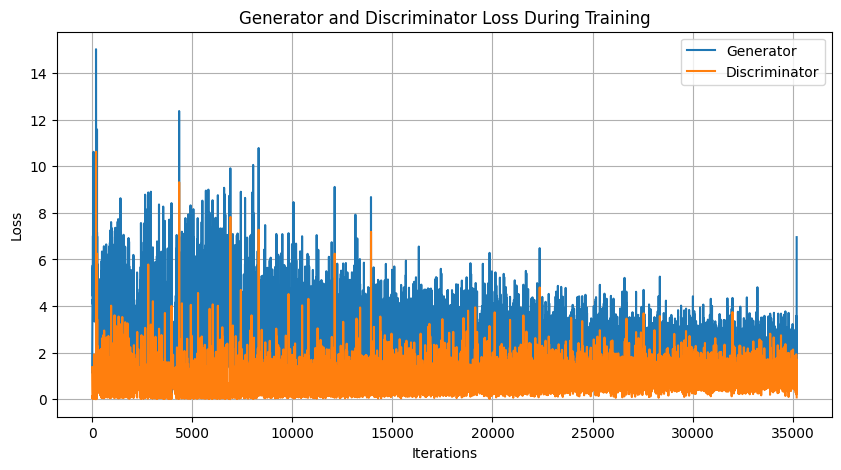

In [ ]:
# Generator and Discriminator Loss During Training

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()



** Loss Analysis:**

The Generator and Discriminator losses were tracked across 50 epochs. Initially, both networks showed instability—typical in adversarial training—manifested by high variance in loss. As training progressed, losses began to stabilize, indicating convergence.

The Generator loss shows periodic spikes, particularly around epoch 6 and 50, suggesting occasional dominance of the Discriminator. However, the overall decreasing trend with rebounding peaks reflects the natural adversarial interplay. The Discriminator loss fluctuates within a lower range, indicating successful differentiation between real and fake images during most epochs.

These patterns validate the model's learning process and suggest that meaningful image synthesis was achieved by the end of training.





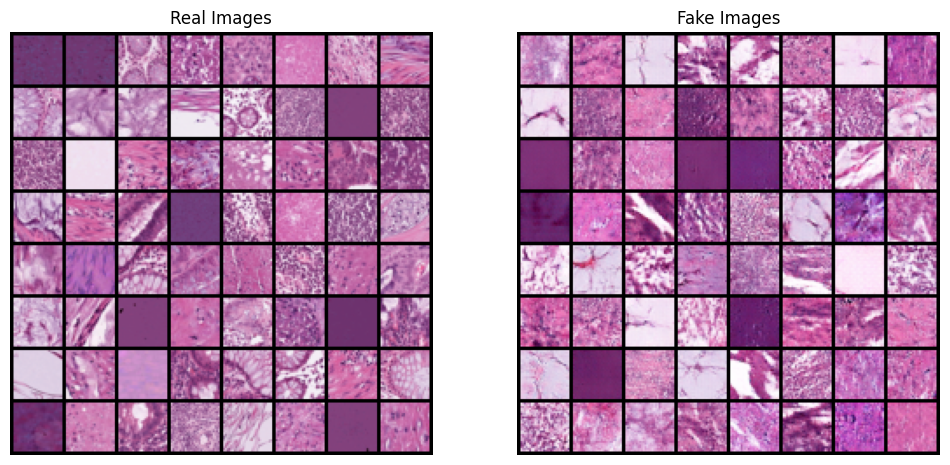

In [ ]:
# Load one batch of real training images
real_batch = next(iter(train_loader))

# Create a figure for side-by-side visualization
plt.figure(figsize=(12, 6))

# Plot real images (Left)
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")

# Take first 64 real images, normalize and transpose for display
plt.imshow(np.transpose(make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

# Plot generated (fake) images (Right)
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
# Use last image grid from training loop (generated samples)
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))

# Display both images
plt.show()


**Implementing a conditional GAN (cGAN) where the generator is conditioned on the pathology class.**

In [ ]:
num_classes = 9  # PathMNIST has 9 tissue classes
latent_dim = 100  # dimension of noise vector
embedding_dim = 50  # dimension for label embedding


In [ ]:
num_classes = 9
latent_dim = 100
embedding_dim = 50


In [ ]:

# -------------------------------
# Conditional Generator Definition
# -------------------------------

class ConditionalGenerator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3, num_classes=9, embed_size=50):
        super(ConditionalGenerator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, embed_size)  # Label embedding layer

        self.init_size = 7  # Target image size is 28x28; we'll upsample from 7x7
        self.l1 = nn.Sequential(nn.Linear(nz + embed_size, ngf * 4 * self.init_size * self.init_size))

        self.main = nn.Sequential(
            nn.BatchNorm2d(ngf * 4),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ngf * 4, ngf * 2, 3, stride=1, padding=1),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(ngf * 2, ngf, 3, stride=1, padding=1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.Conv2d(ngf, nc, 3, stride=1, padding=1),
            nn.Tanh()    # Output pixel range [-1, 1]
        )

    def forward(self, noise, labels):
        label_embedding = self.label_emb(labels)
        gen_input = torch.cat((noise, label_embedding), -1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], -1, 7, 7) # Reshape into feature maps
        img = self.main(out)
        return img


In [ ]:

# -------------------------------
# Conditional Discriminator Definition
# -------------------------------

class ConditionalDiscriminator(nn.Module):
    def __init__(self, nc=3, ndf=64, num_classes=9, embed_size=50):
        super(ConditionalDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, embed_size)

        # Project embedded labels into image-sized masks
        self.label_conv = nn.Sequential(
            nn.Linear(embed_size, 28 * 28),
        )

        self.main = nn.Sequential(
            nn.Conv2d(nc + 1, ndf, 4, 2, 1),  # Concatenate image and label mask as channels
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, 1, 7, 1, 0),
            nn.Sigmoid() # Output a probability
        )

    def forward(self, img, labels):
        label_embedding = self.label_emb(labels)
        label_map = self.label_conv(label_embedding).view(-1, 1, 28, 28)
        x = torch.cat((img, label_map), 1) # Concatenate label mask with image
        return self.main(x).view(-1)


In [ ]:
# -------------------------------
# Initialization
# -------------------------------
cgen = ConditionalGenerator().to(device)
cdisc = ConditionalDiscriminator().to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(cgen.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(cdisc.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Labels
real_label = 1.
fake_label = 0.

# Latent space
latent_dim = 100

# Fixed noise and labels for monitoring or visualization
fixed_noise = torch.randn(64, latent_dim, device=device)
fixed_labels = torch.randint(0, num_classes, (64,), device=device)


In [ ]:
import os
import torchvision.utils as vutils

# Create directory
os.makedirs("cgan_samples", exist_ok=True)

# Trackers
num_epochs = 50
G_losses = []
D_losses = []
img_list = []

print("🚀 Starting Conditional GAN Training...")

for epoch in range(num_epochs):
    for i, (real_images, real_labels) in enumerate(train_loader):
        real_images = real_images.to(device)
        real_labels = real_labels.squeeze().to(device)
        b_size = real_images.size(0)

        # Real labels
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        # ======= Train Discriminator =======
        cdisc.zero_grad()
        output = cdisc(real_images, real_labels)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Fake data
        noise = torch.randn(b_size, latent_dim, device=device)
        fake_labels = torch.randint(0, 9, (b_size,), device=device)
        fake_images = cgen(noise, fake_labels)

        label.fill_(fake_label)
        output = cdisc(fake_images.detach(), fake_labels)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizer_D.step()

        # ======= Train Generator =======
        cgen.zero_grad()
        label.fill_(real_label)  # Fool the discriminator
        output = cdisc(fake_images, fake_labels)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizer_G.step()

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Save images periodically
        if (i % 100 == 0) or (epoch == num_epochs-1 and i == len(train_loader)-1):
            with torch.no_grad():
                fake = cgen(fixed_noise, fixed_labels).detach().cpu()
            img = vutils.make_grid(fake, nrow=8, padding=2, normalize=True)
            img_list.append(img)
            vutils.save_image(fake, f"cgan_samples/epoch_{epoch}_batch_{i}.png", normalize=True)

    print(f"[{epoch+1}/{num_epochs}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}")


🚀 Starting Conditional GAN Training...
[1/50] Loss_D: 0.1578 Loss_G: 6.0610 D(x): 0.8583 D(G(z)): 0.0027/0.0038
[2/50] Loss_D: 0.5168 Loss_G: 1.5690 D(x): 0.9951 D(G(z)): 0.3946/0.2146
[3/50] Loss_D: 0.0417 Loss_G: 3.9550 D(x): 0.9806 D(G(z)): 0.0219/0.0201
[4/50] Loss_D: 1.7175 Loss_G: 0.4676 D(x): 0.9946 D(G(z)): 0.8140/0.6357
[5/50] Loss_D: 2.5650 Loss_G: 0.8540 D(x): 0.1987 D(G(z)): 0.5189/0.4910
[6/50] Loss_D: 1.4894 Loss_G: 0.8853 D(x): 0.9996 D(G(z)): 0.7603/0.4300
[7/50] Loss_D: 3.9380 Loss_G: 0.3878 D(x): 0.0947 D(G(z)): 0.7363/0.6895
[8/50] Loss_D: 2.2130 Loss_G: 1.2297 D(x): 0.1352 D(G(z)): 0.1243/0.3024
[9/50] Loss_D: 1.0503 Loss_G: 9.0179 D(x): 0.3761 D(G(z)): 0.0000/0.0001
[10/50] Loss_D: 2.1106 Loss_G: 0.8495 D(x): 0.2157 D(G(z)): 0.3978/0.5181
[11/50] Loss_D: 3.8466 Loss_G: 6.5365 D(x): 0.0348 D(G(z)): 0.0006/0.0019
[12/50] Loss_D: 1.0249 Loss_G: 1.6008 D(x): 0.3983 D(G(z)): 0.0133/0.2714
[13/50] Loss_D: 13.9339 Loss_G: 13.5446 D(x): 0.0000 D(G(z)): 0.0000/0.0000
[14/50

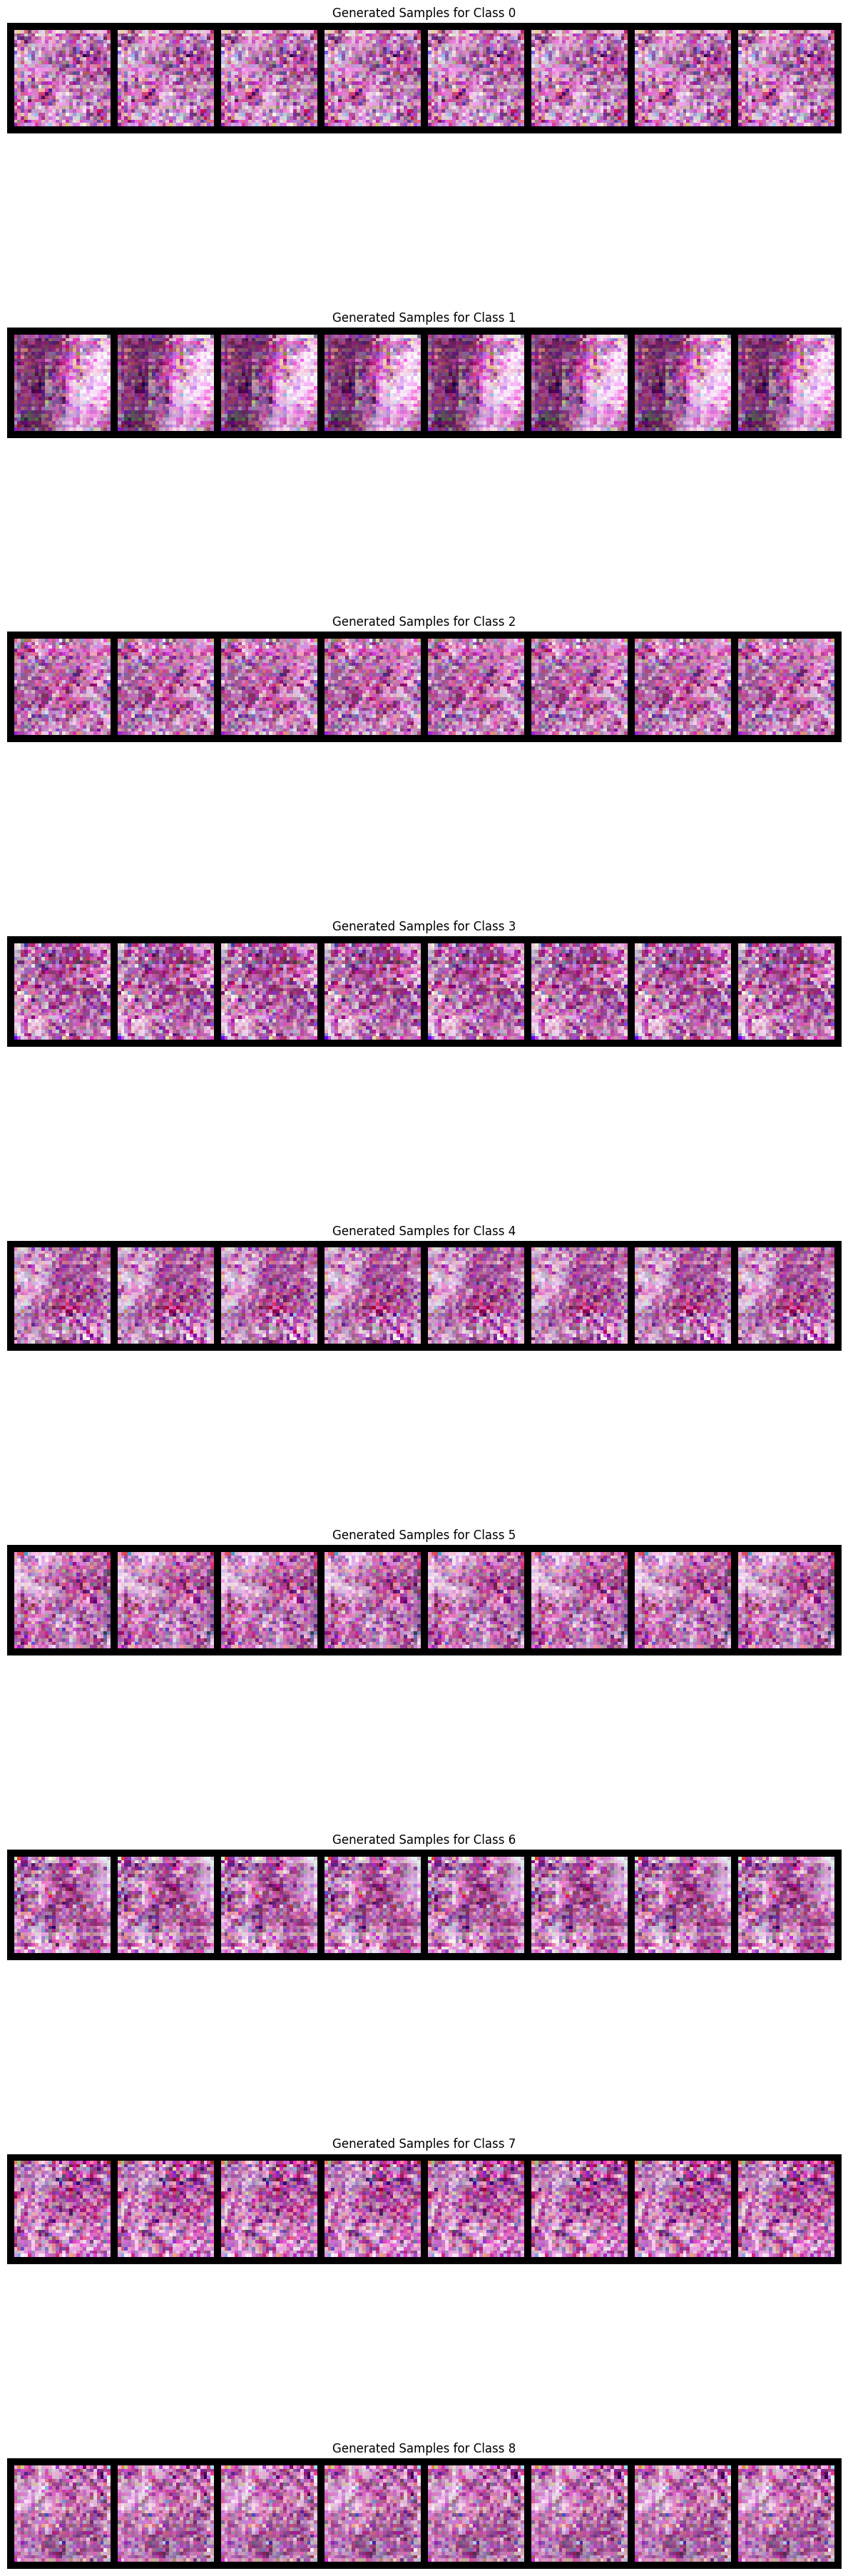

In [ ]:
import torchvision.utils as vutils

# Create 9 rows, each for a class from 0 to 8
cgan_class_grid = []
for class_label in range(9):
    label = torch.full((8,), class_label, dtype=torch.long, device=device)
    noise = torch.randn(8, latent_dim, device=device)
    with torch.no_grad():
        fake_images = cgen(noise, label).detach().cpu()
    grid = vutils.make_grid(fake_images, nrow=8, padding=2, normalize=True)
    cgan_class_grid.append(grid)

# Plot all class-wise generated samples
fig, axes = plt.subplots(9, 1, figsize=(12, 40))
for i, img in enumerate(cgan_class_grid):
    axes[i].imshow(np.transpose(img, (1, 2, 0)))
    axes[i].set_title(f"Generated Samples for Class {i}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()
